
# BrainCharts Hackathon – EDA + Baseline (Team 1)

This notebook builds a **clean, subject-level dataset** and runs **targeted EDA** and a **baseline model** to predict **p-factor**.
- Use **`Yeo2011_7Networks_N1000`** atlas
- Use **`ThickAvg`** only (average cortical thickness)
- Keep **left/right hemispheres separate** (no averaging) for the first run
- Normalize relevant global measures by **eTIV** (Estimated Total Intracranial Volume)
- Merge **demographics** + **brain_measures** + **selected atlas regional features**
- Save **train/test flattened CSVs** for modeling & submission



In [15]:

# ================================================
# 0. SETUP
# ================================================
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# RBC cloud access
from rbclib import RBCPath

# Display
pd.set_option('display.max_columns', 120)
sns.set_context('notebook')

# Paths
rbcdata_path = Path('/home/jovyan/shared/data/RBC')
train_filepath = rbcdata_path / 'train_participants.tsv'
test_filepath  = rbcdata_path / 'test_participants.tsv'

# Atlas/feature config
ATLAS_NAME = 'Yeo2011_7Networks_N1000'   # starting atlas (coarse, interpretable)
FEATURE_NAME = 'ThickAvg'                # use cortical thickness only

# Output paths
out_dir = Path('./outputs')
out_dir.mkdir(exist_ok=True)



## 1. Data Understanding


In [19]:

# Load participants
train_part = pd.read_csv(train_filepath, sep='\t')
test_part  = pd.read_csv(test_filepath,  sep='\t')

print('Train participants:', train_part.shape)
print('Test participants :', test_part.shape)
display(train_part.head(3))
display(test_part.head(3))

# Convenience: list of subject IDs
train_ids = train_part['participant_id'].tolist()
test_ids  = test_part['participant_id'].tolist()

# Example subject print (for path structure sanity)
example_sid = train_ids[0]
print('Example subject:', example_sid)
sub_path = RBCPath(f'rbc://PNC_FreeSurfer/freesurfer/sub-{example_sid}')
print('Subject dir exists? is_dir =', sub_path.is_dir())
for f in sub_path.iterdir():
    print(f)


Train participants: (1067, 15)
Test participants : (534, 15)


,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor
0,1000393599,PNC,PNC1,PNC1,1,15.583333,Male,Black,not Hispanic or Latino,22.15,Right,9th Grade,Complete primary,Complete secondary,0.589907
1,1001970838,PNC,PNC1,PNC1,1,17.833333,Male,Other,Hispanic or Latino,23.98,Right,11th Grade,Complete tertiary,Complete tertiary,-0.659061
2,1007995238,PNC,PNC1,PNC1,1,13.750000,Female,Other,not Hispanic or Latino,23.77,Right,6th Grade,Complete tertiary,Complete primary,-1.608375


,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor
0,1000881804,PNC,PNC1,PNC1,1,14.916667,Male,Black,not Hispanic or Latino,21.52,Right,7th Grade,Complete secondary,Complete secondary,NaN
1,100527940,PNC,PNC1,PNC1,1,8.250000,Male,Black,not Hispanic or Latino,NaN,Ambidextrous,1st Grade,Complete secondary,Complete primary,NaN
2,1006151876,PNC,PNC1,PNC1,1,21.500000,Female,Other,not Hispanic or Latino,NaN,Right,12th Grade,Complete tertiary,Complete secondary,NaN


Example subject: 1000393599
Subject dir exists? is_dir = True
rbc://PNC_FreeSurfer//home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1000393599/sub-1000393599_brainmeasures.json
rbc://PNC_FreeSurfer//home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1000393599/sub-1000393599_brainmeasures.tsv
rbc://PNC_FreeSurfer//home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1000393599/sub-1000393599_freesurfer.tar.xz
rbc://PNC_FreeSurfer//home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1000393599/sub-1000393599_fsLR_den-164k.tar.xz
rbc://PNC_FreeSurfer//home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1000393599/sub-1000393599_fsaverage.tar.xz
rbc://PNC_FreeSurfer//home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1000393599/sub-1000393599_regionsurfacestats.tsv



### Helper functions


In [20]:

import pandas as pd
import numpy as np
import re

def _subject_dir(subject_id: str):
    from rbclib import RBCPath
    return RBCPath(f'rbc://PNC_FreeSurfer/freesurfer/sub-{subject_id}')

def _brain_measures_path(subject_id: str):
    return _subject_dir(subject_id) / f'sub-{subject_id}_brainmeasures.tsv'

def _region_stats_path(subject_id: str):
    return _subject_dir(subject_id) / f'sub-{subject_id}_regionsurfacestats.tsv'

def load_brain_measures(subject_id: str) -> pd.DataFrame:
    p = _brain_measures_path(subject_id)
    if not p.exists():
        raise FileNotFoundError(f'Missing brain measures for {subject_id}: {p}')
    with p.open('r') as f:
        df = pd.read_csv(f, sep='\t')
    if 'subject_id' not in df.columns:
        df.insert(0, 'subject_id', subject_id)
    else:
        df['subject_id'] = subject_id
    return df

def normalize_by_etiv(df: pd.DataFrame, etiv_col: str = 'EstimatedTotalIntraCranialVol_eTIV') -> pd.DataFrame:
    if etiv_col not in df.columns:
        return df
    etiv = df[etiv_col].astype(float).replace(0, np.nan)
    df = df.copy()
    pattern = re.compile(r'(Vol|Volume|SurfArea|GrayVol)', re.IGNORECASE)
    for col in df.columns:
        if col == etiv_col: 
            continue
        if pattern.search(col) and pd.api.types.is_numeric_dtype(df[col]):
            df[col + '_eTIVnorm'] = df[col] / etiv
    return df

def load_region_features(subject_id: str, atlas: str, feature: str = 'ThickAvg', keep_hemis=True) -> pd.DataFrame:
    p = _region_stats_path(subject_id)
    if not p.exists():
        raise FileNotFoundError(f'Missing region stats for {subject_id}: {p}')
    with p.open('r') as f:
        df = pd.read_csv(f, sep='\t')
    df = df[df['atlas'] == atlas].copy()
    if df.empty:
        return pd.DataFrame({'subject_id': [subject_id]})
    required = ['subject_id', 'hemisphere', 'StructName', feature]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f'Missing columns in regionsurfacestats for {subject_id}: {missing}')
    if keep_hemis:
        df['colname'] = df['hemisphere'].str.lower() + '_' + df['StructName'].astype(str) + '_' + feature
        wide = df.pivot_table(index='subject_id', columns='colname', values=feature, aggfunc='mean')
    else:
        tmp = df.groupby(['subject_id', 'StructName'])[feature].mean().reset_index()
        tmp['colname'] = tmp['StructName'].astype(str) + '_' + feature
        wide = tmp.pivot_table(index='subject_id', columns='colname', values=feature, aggfunc='mean')
    wide = wide.reset_index()
    wide['subject_id'] = wide['subject_id'].astype(str)
    return wide

from tqdm.auto import tqdm

def build_subject_level_table(subject_ids, atlas: str, feature: str = 'ThickAvg', keep_hemis=True,
                              show_progress=True) -> pd.DataFrame:
    rows = []
    it = tqdm(subject_ids, desc=f'Extracting {atlas}/{feature}') if show_progress else subject_ids
    for sid in it:
        try:
            bm = load_brain_measures(sid)
            rg = load_region_features(sid, atlas=atlas, feature=feature, keep_hemis=keep_hemis)
    
            # 🔧 Normalize ID types before merging
            bm['subject_id'] = bm['subject_id'].astype(str)
            rg['subject_id'] = rg['subject_id'].astype(str)
    
            bm_norm = normalize_by_etiv(bm)
            bm_merged = bm.merge(bm_norm.drop(columns=['subject_id']), left_index=True, right_index=True, how='left')
            merged = pd.merge(rg, bm_merged, on='subject_id', how='left')
            rows.append(merged)
        except Exception as e:
            print(f'[WARN] {sid}: {e}')

    if not rows:
        return pd.DataFrame(columns=['participant_id'])
    df = pd.concat(rows, ignore_index=True)
    df = df.groupby('subject_id').first().reset_index()
    
    # Normalize ID for consistency
    df['participant_id'] = df['subject_id'].astype(str).str.replace('^sub-', '', regex=True)
    df.drop(columns=['subject_id'], inplace=True)
    
    return df


## 2. Build Subject-level Train/Test Tables


In [21]:

ATLAS_NAME = 'Yeo2011_7Networks_N1000'
FEATURE_NAME = 'ThickAvg'

train_features = build_subject_level_table(train_ids, atlas=ATLAS_NAME, feature=FEATURE_NAME, keep_hemis=True)
test_features  = build_subject_level_table(test_ids,  atlas=ATLAS_NAME, feature=FEATURE_NAME, keep_hemis=True)

print('Train features shape:', train_features.shape)
print('Test features shape :', test_features.shape)

Extracting Yeo2011_7Networks_N1000/ThickAvg:   0%|          | 0/1067 [00:00<?, ?it/s]

[WARN] 1342487188: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1342487188/sub-1342487188_brainmeasures.tsv'
[WARN] 1649551035: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1649551035/sub-1649551035_brainmeasures.tsv'
[WARN] 2003542642: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-2003542642/sub-2003542642_brainmeasures.tsv'
[WARN] 219325366: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-219325366/sub-219325366_brainmeasures.tsv'
[WARN] 2249226316: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-2249226316/sub-2249226316_brainmeasures.tsv'
[WARN] 4184549693: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-4184549693/sub-4184549693_brainmeasures.tsv'
[WARN] 495793681: [Errno 2] No such f

Extracting Yeo2011_7Networks_N1000/ThickAvg:   0%|          | 0/534 [00:00<?, ?it/s]

[WARN] 4205323727: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-4205323727/sub-4205323727_brainmeasures.tsv'
[WARN] 533698126: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-533698126/sub-533698126_brainmeasures.tsv'
Train features shape: (1060, 814)
Test features shape : (532, 814)


ValueError: You are trying to merge on int64 and object columns for key 'participant_id'. If you wish to proceed you should use pd.concat

In [43]:
# --- Fix ID types for consistent merge ---
train_part['participant_id'] = train_part['participant_id'].astype(str)
test_part['participant_id'] = test_part['participant_id'].astype(str)
train_features['participant_id'] = train_features['participant_id'].astype(str)
test_features['participant_id'] = test_features['participant_id'].astype(str)

# --- Merge participants (demographics) + features ---
train_df = pd.merge(train_part, train_features, on='participant_id', how='left')
test_df  = pd.merge(test_part,  test_features,  on='participant_id', how='left')

print('✅ Merged train_df:', train_df.shape)
print('✅ Merged test_df :', test_df.shape)

# Check for missing merges (sanity)
missing_train = train_df['p_factor'].isna().sum()
missing_feats = train_df.filter(like='lh_').isna().all(axis=1).sum()
print(f'Missing p_factor rows: {missing_train}, missing all features: {missing_feats}')

train_df.head(3)


✅ Merged train_df: (1067, 828)
✅ Merged test_df : (534, 828)
Missing p_factor rows: 0, missing all features: 7


,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor,lh_7Networks_1_ThickAvg,lh_7Networks_2_ThickAvg,lh_7Networks_3_ThickAvg,lh_7Networks_4_ThickAvg,lh_7Networks_5_ThickAvg,lh_7Networks_6_ThickAvg,lh_7Networks_7_ThickAvg,lh_FreeSurfer_Defined_Medial_Wall_ThickAvg,rh_7Networks_1_ThickAvg,rh_7Networks_2_ThickAvg,rh_7Networks_3_ThickAvg,rh_7Networks_4_ThickAvg,rh_7Networks_5_ThickAvg,rh_7Networks_6_ThickAvg,rh_7Networks_7_ThickAvg,rh_FreeSurfer_Defined_Medial_Wall_ThickAvg,session_id_x,lh_euler_x,rh_euler_x,lh_holes_x,rh_holes_x,Cortex_NumVert_lh_x,Cortex_PialSurfArea_lh_x,Cortex_MeanThickness_lh_x,BrainSeg_BrainSegVol_lh_x,BrainSegNotVent_BrainSegVolNotVent_lh_x,BrainSegNotVentSurf_BrainSegVolNotVentSurf_lh_x,Cortex_CortexVol_lh_x,SupraTentorial_SupraTentorialVol_lh_x,SupraTentorialNotVent_SupraTentorialVolNotVent_lh_x,EstimatedTotalIntraCranialVol_eTIV_lh_x,Cortex_NumVert_rh_x,Cortex_PialSurfArea_rh_x,Cortex_MeanThickness_rh_x,BrainSeg_BrainSegVol_rh_x,BrainSegNotVent_BrainSegVolNotVent_rh_x,BrainSegNotVentSurf_BrainSegVolNotVentSurf_rh_x,Cortex_CortexVol_rh_x,SupraTentorial_SupraTentorialVol_rh_x,SupraTentorialNotVent_SupraTentorialVolNotVent_rh_x,EstimatedTotalIntraCranialVol_eTIV_rh_x,Left_Lateral_Ventricle_NVoxels_x,Left_Inf_Lat_Vent_NVoxels_x,Left_Cerebellum_White_Matter_NVoxels_x,Left_Cerebellum_Cortex_NVoxels_x,...,Left_Inf_Lat_Vent_Volume_mm3_eTIVnorm,Left_Cerebellum_White_Matter_Volume_mm3_eTIVnorm,Left_Cerebellum_Cortex_Volume_mm3_eTIVnorm,Left_Thalamus_Proper_Volume_mm3_eTIVnorm,Left_Caudate_Volume_mm3_eTIVnorm,Left_Putamen_Volume_mm3_eTIVnorm,Left_Pallidum_Volume_mm3_eTIVnorm,Third_Ventricle_Volume_mm3_eTIVnorm,Fourth_Ventricle_Volume_mm3_eTIVnorm,Brain_Stem_Volume_mm3_eTIVnorm,Left_Hippocampus_Volume_mm3_eTIVnorm,Left_Amygdala_Volume_mm3_eTIVnorm,CSF_Volume_mm3_eTIVnorm,Left_Accumbens_area_Volume_mm3_eTIVnorm,Left_VentralDC_Volume_mm3_eTIVnorm,Left_vessel_Volume_mm3_eTIVnorm,Left_choroid_plexus_Volume_mm3_eTIVnorm,Right_Lateral_Ventricle_Volume_mm3_eTIVnorm,Right_Inf_Lat_Vent_Volume_mm3_eTIVnorm,Right_Cerebellum_White_Matter_Volume_mm3_eTIVnorm,Right_Cerebellum_Cortex_Volume_mm3_eTIVnorm,Right_Thalamus_Proper_Volume_mm3_eTIVnorm,Right_Caudate_Volume_mm3_eTIVnorm,Right_Putamen_Volume_mm3_eTIVnorm,Right_Pallidum_Volume_mm3_eTIVnorm,Right_Hippocampus_Volume_mm3_eTIVnorm,Right_Amygdala_Volume_mm3_eTIVnorm,Right_Accumbens_area_Volume_mm3_eTIVnorm,Right_VentralDC_Volume_mm3_eTIVnorm,Right_vessel_Volume_mm3_eTIVnorm,Right_choroid_plexus_Volume_mm3_eTIVnorm,Fifth_Ventricle_Volume_mm3_eTIVnorm,WM_hypointensities_Volume_mm3_eTIVnorm,Left_WM_hypointensities_Volume_mm3_eTIVnorm,Right_WM_hypointensities_Volume_mm3_eTIVnorm,non_WM_hypointensities_Volume_mm3_eTIVnorm,Left_non_WM_hypointensities_Volume_mm3_eTIVnorm,Right_non_WM_hypointensities_Volume_mm3_eTIVnorm,Optic_Chiasm_Volume_mm3_eTIVnorm,CC_Posterior_Volume_mm3_eTIVnorm,CC_Mid_Posterior_Volume_mm3_eTIVnorm,CC_Central_Volume_mm3_eTIVnorm,CC_Mid_Anterior_Volume_mm3_eTIVnorm,CC_Anterior_Volume_mm3_eTIVnorm,BrainSeg_BrainSegVol_eTIVnorm,BrainSegNotVent_BrainSegVolNotVent_eTIVnorm,BrainSegNotVentSurf_BrainSegVolNotVentSurf_eTIVnorm,VentricleChoroidVol_eTIVnorm,lhCortex_lhCortexVol_eTIVnorm,rhCortex_rhCortexVol_eTIVnorm,Cortex_CortexVol_eTIVnorm,lhCerebralWhiteMatter_lhCerebralWhiteMatterVol_eTIVnorm,rhCerebralWhiteMatter_rhCerebralWhiteMatterVol_eTIVnorm,CerebralWhiteMatter_CerebralWhiteMatterVol_eTIVnorm,SubCortGray_SubCortGrayVol_eTIVnorm,TotalGray_TotalGrayVol_eTIVnorm,SupraTentorial_SupraTentorialVol_eTIVnorm,SupraTentorialNotVent_SupraTentorialVolNotVent_eTIVnorm,SupraTentorialNotVentVox_SupraTentorialVolNotVentVox_eTIVnorm,Mask_MaskVol_eTIVnorm
0,1000393599,PNC,PNC1,PNC1,1,15.583333,Male,Black,not Hispanic or Latino,22.15,Right,9th Grade,Complete primary,Complete secondary,0.589907,2.122,2.506,2.526,2.906,3.040,2.728,2.947,0.885,2.233,2.579,2.611,2.909,3.196,2.696,2.878,

In [33]:
# === Cell 1: Extract brain measures for participants that exist in train_df ===
from tqdm.auto import tqdm

# Ensure participant_id is string
train_df['participant_id'] = train_df['participant_id'].astype(str)

# Collect just the participants already in your merged df
subject_ids = train_df['participant_id'].unique().tolist()

# Build brain measure dataframe for these subjects
brain_df = []
for sid in tqdm(subject_ids, desc="Rebuilding brain measures"):
    try:
        bm = load_brain_measures(sid)
        bm = normalize_by_etiv(bm)  # normalize by eTIV
        bm['participant_id'] = sid
        brain_df.append(bm)
    except Exception as e:
        print(f"[WARN] {sid}: {e}")

# Combine everything
brain_df = pd.concat(brain_df, ignore_index=True) if brain_df else pd.DataFrame(columns=['participant_id'])
print(f"✅ Extracted brain measures for {len(brain_df)} participants")


Rebuilding brain measures:   0%|          | 0/1067 [00:00<?, ?it/s]

[WARN] 1342487188: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1342487188/sub-1342487188_brainmeasures.tsv'
[WARN] 1649551035: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-1649551035/sub-1649551035_brainmeasures.tsv'
[WARN] 2003542642: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-2003542642/sub-2003542642_brainmeasures.tsv'
[WARN] 219325366: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-219325366/sub-219325366_brainmeasures.tsv'
[WARN] 2249226316: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-2249226316/sub-2249226316_brainmeasures.tsv'
[WARN] 4184549693: [Errno 2] No such file or directory: '/home/jovyan/shared/data/RBC/PNC_FreeSurfer/freesurfer/sub-4184549693/sub-4184549693_brainmeasures.tsv'
[WARN] 495793681: [Errno 2] No such f

In [39]:
brain_df

,subject_id,session_id,lh_euler,rh_euler,lh_holes,rh_holes,Cortex_NumVert_lh,Cortex_PialSurfArea_lh,Cortex_MeanThickness_lh,BrainSeg_BrainSegVol_lh,BrainSegNotVent_BrainSegVolNotVent_lh,BrainSegNotVentSurf_BrainSegVolNotVentSurf_lh,Cortex_CortexVol_lh,SupraTentorial_SupraTentorialVol_lh,SupraTentorialNotVent_SupraTentorialVolNotVent_lh,EstimatedTotalIntraCranialVol_eTIV_lh,Cortex_NumVert_rh,Cortex_PialSurfArea_rh,Cortex_MeanThickness_rh,BrainSeg_BrainSegVol_rh,BrainSegNotVent_BrainSegVolNotVent_rh,BrainSegNotVentSurf_BrainSegVolNotVentSurf_rh,Cortex_CortexVol_rh,SupraTentorial_SupraTentorialVol_rh,SupraTentorialNotVent_SupraTentorialVolNotVent_rh,EstimatedTotalIntraCranialVol_eTIV_rh,Left_Lateral_Ventricle_NVoxels,Left_Inf_Lat_Vent_NVoxels,Left_Cerebellum_White_Matter_NVoxels,Left_Cerebellum_Cortex_NVoxels,Left_Thalamus_Proper_NVoxels,Left_Caudate_NVoxels,Left_Putamen_NVoxels,Left_Pallidum_NVoxels,Third_Ventricle_NVoxels,Fourth_Ventricle_NVoxels,Brain_Stem_NVoxels,Left_Hippocampus_NVoxels,Left_Amygdala_NVoxels,CSF_NVoxels,Left_Accumbens_area_NVoxels,Left_VentralDC_NVoxels,Left_vessel_NVoxels,Left_choroid_plexus_NVoxels,Right_Lateral_Ventricle_NVoxels,Right_Inf_Lat_Vent_NVoxels,Right_Cerebellum_White_Matter_NVoxels,Right_Cerebellum_Cortex_NVoxels,Right_Thalamus_Proper_NVoxels,Right_Caudate_NVoxels,Right_Putamen_NVoxels,Right_Pallidum_NVoxels,Right_Hippocampus_NVoxels,Right_Amygdala_NVoxels,Right_Accumbens_area_NVoxels,Right_VentralDC_NVoxels,Right_vessel_NVoxels,Right_choroid_plexus_NVoxels,Fifth_Ventricle_NVoxels,WM_hypointensities_NVoxels,...,Left_Cerebellum_White_Matter_Volume_mm3_eTIVnorm,Left_Cerebellum_Cortex_Volume_mm3_eTIVnorm,Left_Thalamus_Proper_Volume_mm3_eTIVnorm,Left_Caudate_Volume_mm3_eTIVnorm,Left_Putamen_Volume_mm3_eTIVnorm,Left_Pallidum_Volume_mm3_eTIVnorm,Third_Ventricle_Volume_mm3_eTIVnorm,Fourth_Ventricle_Volume_mm3_eTIVnorm,Brain_Stem_Volume_mm3_eTIVnorm,Left_Hippocampus_Volume_mm3_eTIVnorm,Left_Amygdala_Volume_mm3_eTIVnorm,CSF_Volume_mm3_eTIVnorm,Left_Accumbens_area_Volume_mm3_eTIVnorm,Left_VentralDC_Volume_mm3_eTIVnorm,Left_vessel_Volume_mm3_eTIVnorm,Left_choroid_plexus_Volume_mm3_eTIVnorm,Right_Lateral_Ventricle_Volume_mm3_eTIVnorm,Right_Inf_Lat_Vent_Volume_mm3_eTIVnorm,Right_Cerebellum_White_Matter_Volume_mm3_eTIVnorm,Right_Cerebellum_Cortex_Volume_mm3_eTIVnorm,Right_Thalamus_Proper_Volume_mm3_eTIVnorm,Right_Caudate_Volume_mm3_eTIVnorm,Right_Putamen_Volume_mm3_eTIVnorm,Right_Pallidum_Volume_mm3_eTIVnorm,Right_Hippocampus_Volume_mm3_eTIVnorm,Right_Amygdala_Volume_mm3_eTIVnorm,Right_Accumbens_area_Volume_mm3_eTIVnorm,Right_VentralDC_Volume_mm3_eTIVnorm,Right_vessel_Volume_mm3_eTIVnorm,Right_choroid_plexus_Volume_mm3_eTIVnorm,Fifth_Ventricle_Volume_mm3_eTIVnorm,WM_hypointensities_Volume_mm3_eTIVnorm,Left_WM_hypointensities_Volume_mm3_eTIVnorm,Right_WM_hypointensities_Volume_mm3_eTIVnorm,non_WM_hypointensities_Volume_mm3_eTIVnorm,Left_non_WM_hypointensities_Volume_mm3_eTIVnorm,Right_non_WM_hypointensities_Volume_mm3_eTIVnorm,Optic_Chiasm_Volume_mm3_eTIVnorm,CC_Posterior_Volume_mm3_eTIVnorm,CC_Mid_Posterior_Volume_mm3_eTIVnorm,CC_Central_Volume_mm3_eTIVnorm,CC_Mid_Anterior_Volume_mm3_eTIVnorm,CC_Anterior_Volume_mm3_eTIVnorm,BrainSeg_BrainSegVol_eTIVnorm,BrainSegNotVent_BrainSegVolNotVent_eTIVnorm,BrainSegNotVentSurf_BrainSegVolNotVentSurf_eTIVnorm,VentricleChoroidVol_eTIVnorm,lhCortex_lhCortexVol_eTIVnorm,rhCortex_rhCortexVol_eTIVnorm,Cortex_CortexVol_eTIVnorm,lhCerebralWhiteMatter_lhCerebralWhiteMatterVol_eTIVnorm,rhCerebralWhiteMatter_rhCerebralWhiteMatterVol_eTIVnorm,CerebralWhiteMatter_CerebralWhiteMatterVol_eTIVnorm,SubCortGray_SubCortGrayVol_eTIVnorm,TotalGray_TotalGrayVol_eTIVnorm,SupraTentorial_SupraTentorialVol_eTIVnorm,SupraTentorialNotVent_SupraTentorialVolNotVent_eTIVnorm,SupraTentorialNotVentVox_SupraTentorialVolNotVentVox_eTIVnorm,Mask_MaskVol_eTIVnorm,participant_id
0,1000393599,NaN,-192.0,-152.0,97.0,77.0,135628.0,108937.0,2.63309,1230074.0,1215638.0,1.215627e+06,538208.285602,1.081472e+06,1.

In [44]:
train_df.columns

Index(['participant_id', 'study', 'study_site', 'session_id', 'wave', 'age',
       'sex', 'race', 'ethnicity', 'bmi',
       ...
       'Cortex_CortexVol_eTIVnorm',
       'lhCerebralWhiteMatter_lhCerebralWhiteMatterVol_eTIVnorm',
       'rhCerebralWhiteMatter_rhCerebralWhiteMatterVol_eTIVnorm',
       'CerebralWhiteMatter_CerebralWhiteMatterVol_eTIVnorm',
       'SubCortGray_SubCortGrayVol_eTIVnorm',
       'TotalGray_TotalGrayVol_eTIVnorm',
       'SupraTentorial_SupraTentorialVol_eTIVnorm',
       'SupraTentorialNotVent_SupraTentorialVolNotVent_eTIVnorm',
       'SupraTentorialNotVentVox_SupraTentorialVolNotVentVox_eTIVnorm',
       'Mask_MaskVol_eTIVnorm'],
      dtype='object', length=828)

In [46]:
train_df

,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor,lh_7Networks_1_ThickAvg,lh_7Networks_2_ThickAvg,lh_7Networks_3_ThickAvg,lh_7Networks_4_ThickAvg,lh_7Networks_5_ThickAvg,lh_7Networks_6_ThickAvg,lh_7Networks_7_ThickAvg,lh_FreeSurfer_Defined_Medial_Wall_ThickAvg,rh_7Networks_1_ThickAvg,rh_7Networks_2_ThickAvg,rh_7Networks_3_ThickAvg,rh_7Networks_4_ThickAvg,rh_7Networks_5_ThickAvg,rh_7Networks_6_ThickAvg,rh_7Networks_7_ThickAvg,rh_FreeSurfer_Defined_Medial_Wall_ThickAvg
0,1000393599,PNC,PNC1,PNC1,1,15.583333,Male,Black,not Hispanic or Latino,22.15,Right,9th Grade,Complete primary,Complete secondary,0.589907,2.122,2.506,2.526,2.906,3.040,2.728,2.947,0.885,2.233,2.579,2.611,2.909,3.196,2.696,2.878,0.799
1,1001970838,PNC,PNC1,PNC1,1,17.833333,Male,Other,Hispanic or Latino,23.98,Right,11th Grade,Complete tertiary,Complete tertiary,-0.659061,2.150,2.556,2.478,2.825,2.903,2.662,2.795,0.888,2.193,2.553,2.437,2.787,2.884,2.637,2.810,0.874
2,1007995238,PNC,PNC1,PNC1,1,13.750000,Female,Other,not Hispanic or Latino,23.77,Right,6th Grade,Complete tertiary,Complete primary,-1.608375,2.285,2.609,2.744,2.991,2.929,2.680,2.889,0.906,2.349,2.636,2.691,3.020,2.921,2.722,2.984,0.903
3,1011497669,PNC,PNC1,PNC1,1,16.666667,Male,White,not Hispanic or Latino,29.68,Right,9th Grade,Complete tertiary,Complete tertiary,-1.233807,2.218,2.543,2.627,2.873,3.023,2.731,2.952,0.915,2.268,2.610,2.592,2.907,2.922,2.680,2.915,0.924
4,1017092387,PNC,PNC1,PNC1,1,18.666667,Female,Black,not Hispanic or Latino,23.24,Right,11th Grade,Complete primary,Complete primary,-0.923100,2.060,2.431,2.421,2.759,2.912,2.660,2.821,0.875,2.092,2.409,2.495,2.938,2.929,2.702,2.914,0.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,983504031,PNC,PNC1,PNC1,1,16.083333,Male,Black,not Hispanic or Latino,22.81,Left,9th Grade,Complete primary,Complete primary,-1.262053,2.124,2.574,2.501,2.872,3.148,2.704,2.864,0.938,2.171,2.607,2.635,2.906,3.142,2.736,2.901,0.947
1063,985910486,PNC,PNC1,PNC1,1,18.750000,Female,Black,not Hispanic or Latino,24.50,Right,12th Grade,Complete primary,NaN,-1.233807,2.117,2.487,2.433,2.808,3.026,2.653,2.910,0.787,2.207,2.500,2.507,2.798,2.889,2.712,2.852,0.755
1064,986035435,PNC,PNC1,PNC1,1,9.916667,Female,White,not Hispanic or Latino,NaN,Right,3rd Grade,Complete primary,Complete primary,-0.872749,2.220,2.649,2.682,2.967,3.131,2.723,3.022,0.955,2.331,2.623,2.592,2.951,3.089,2.721,2.966,1.012
1065,993394555,PNC,PNC1,PNC1,1,19.500000,Female,White,not Hispanic or Latino,NaN,Right,Some College,Complete secondary,Complete secondary,-1.420477,2.217,2.628,2.603,2.991,3.007,2.687,2.923,0.904,2.242,2.617,2.619,2.877,3.004,2.717,2.939,0.966


In [47]:
from pathlib import Path

# === CONFIG ===
save_dir = Path("per_atlas_data")
save_dir.mkdir(exist_ok=True, parents=True)
atlas_tag = ATLAS_NAME.replace("/", "_")  # sanitize atlas name

def clean_and_merge(base_df, brain_df, split_name):
    """Cleans old NaN columns, merges, and returns merged DataFrame."""
    print(f"\n🚀 Processing {split_name} set...")

    # Step 1: Drop NaN-only columns
    base_df = base_df.dropna(axis=1, how="all")

    # Step 2: Deduplicate
    base_df = base_df.loc[:, ~base_df.columns.duplicated()]
    brain_df = brain_df.loc[:, ~brain_df.columns.duplicated()]

    # Step 3: ID normalization
    base_df["participant_id"] = base_df["participant_id"].astype(str)
    brain_df["participant_id"] = brain_df["participant_id"].astype(str)

    # Step 4: Merge cleanly
    merged = pd.merge(
        base_df,
        brain_df,
        on="participant_id",
        how="left",
        validate="one_to_one"
    )

    # Step 5: Diagnostics
    print(f"✅ {split_name} merged shape: {merged.shape}")
    print(f"Rows before: {len(base_df)}, brain_df: {len(brain_df)}")
    missing = merged["participant_id"].isna().sum()
    print(f"Missing participant_id rows after merge: {missing}")

    return merged


# === RUN CLEAN MERGES ===
train_merged = clean_and_merge(train_df, brain_df, "train")
test_merged = clean_and_merge(test_df, brain_df, "test")

# === SAVE RESULTS ===
train_path = save_dir / f"train_merged_{atlas_tag}.parquet"
test_path = save_dir / f"test_merged_{atlas_tag}.parquet"

train_merged.to_parquet(train_path, index=False)
test_merged.to_parquet(test_path, index=False)

print(f"\n💾 Saved clean train → {train_path}")
print(f"💾 Saved clean test  → {test_path}")



🚀 Processing train set...
✅ train merged shape: (1067, 391)
Rows before: 1067, brain_df: 1060
Missing participant_id rows after merge: 0

🚀 Processing test set...
✅ test merged shape: (534, 390)
Rows before: 534, brain_df: 1060
Missing participant_id rows after merge: 0

💾 Saved clean train → per_atlas_data/train_merged_Yeo2011_7Networks_N1000.parquet
💾 Saved clean test  → per_atlas_data/test_merged_Yeo2011_7Networks_N1000.parquet



## 3. Targeted EDA (Fast)


bmi                                         0.322399
parent_2_education                          0.095595
parent_1_education                          0.014995
Left_non_WM_hypointensities_normMin         0.006560
non_WM_hypointensities_normMin              0.006560
Right_WM_hypointensities_normMin            0.006560
Left_WM_hypointensities_normMin             0.006560
WM_hypointensities_normMin                  0.006560
Fifth_Ventricle_normMin                     0.006560
Left_Cerebellum_White_Matter_normMax        0.006560
Left_Hippocampus_normStdDev                 0.006560
Left_vessel_normMin                         0.006560
Fourth_Ventricle_normStdDev                 0.006560
Third_Ventricle_normStdDev                  0.006560
Left_Pallidum_normStdDev                    0.006560
Left_Putamen_normStdDev                     0.006560
Left_Caudate_normStdDev                     0.006560
Right_Cerebellum_White_Matter_normStdDev    0.006560
Right_Thalamus_Proper_normMin               0.

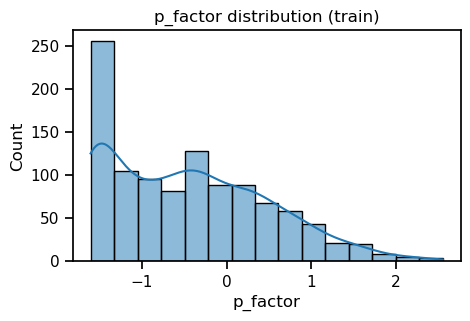

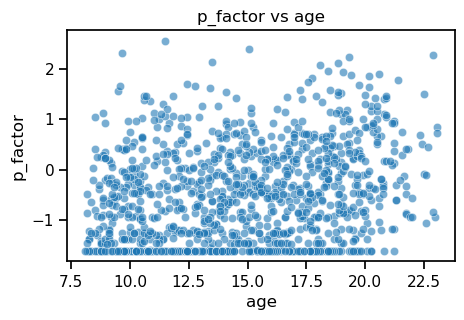

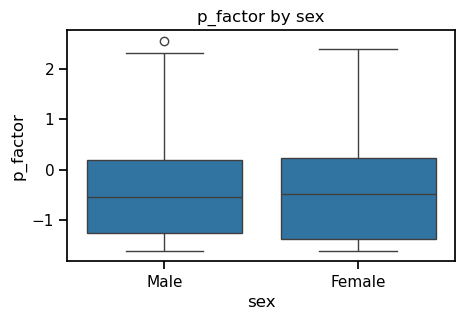

/tmp/ipykernel_277/1113258022.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


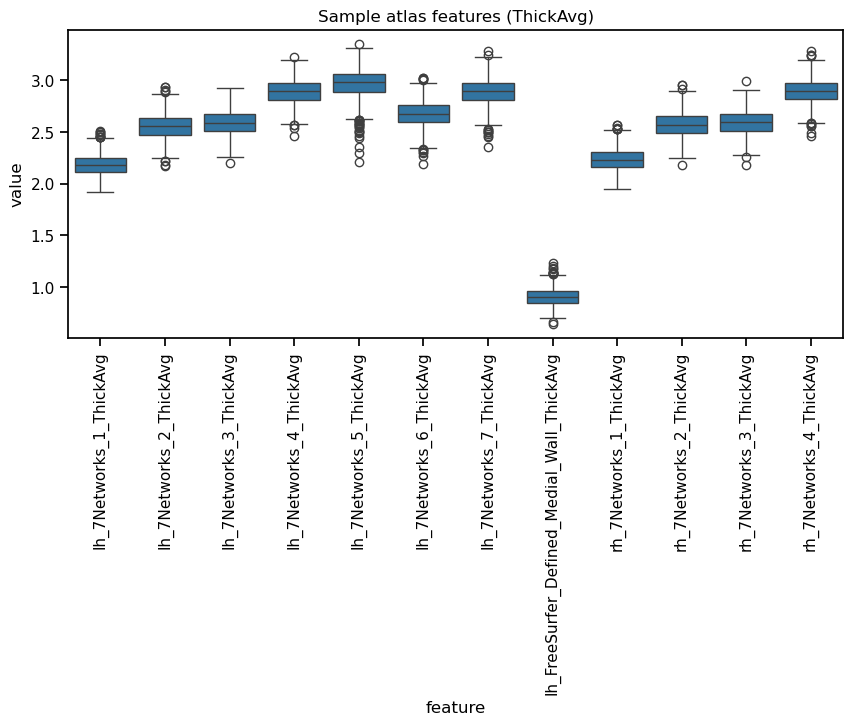

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


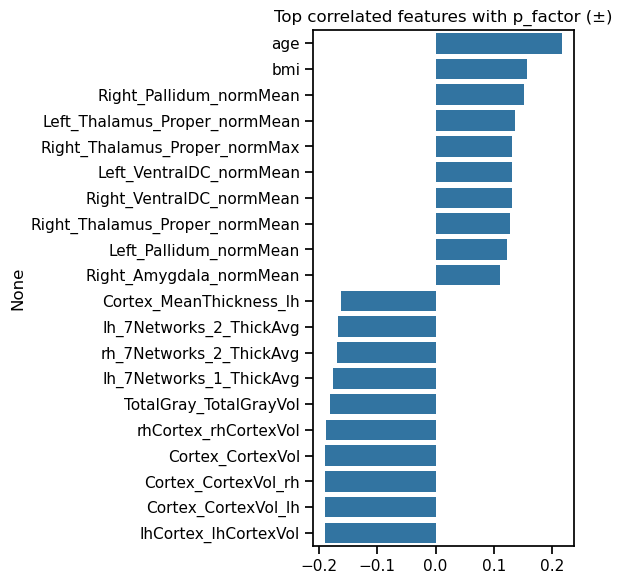

In [48]:

# Missingness
missing = train_merged.isna().mean().sort_values(ascending=False)
display(missing.head(20))

# p_factor distribution
if 'p_factor' in train_merged.columns:
    plt.figure(figsize=(5,3))
    sns.histplot(train_df['p_factor'].dropna(), kde=True)
    plt.title('p_factor distribution (train)')
    plt.show()

# Demographic checks
if 'age' in train_merged.columns and 'p_factor' in train_merged.columns:
    plt.figure(figsize=(5,3))
    sns.scatterplot(data=train_df, x='age', y='p_factor', alpha=0.6)
    plt.title('p_factor vs age')
    plt.show()

if 'sex' in train_merged.columns and 'p_factor' in train_merged.columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(data=train_df, x='sex', y='p_factor')
    plt.title('p_factor by sex')
    plt.show()

# Sample atlas feature distributions
atlas_cols = [c for c in train_merged.columns if c.startswith('lh_') or c.startswith('rh_')]
sample_atlas_cols = atlas_cols[:12]
if sample_atlas_cols:
    _tmp = train_merged[sample_atlas_cols].melt(var_name='feature', value_name='value')
    plt.figure(figsize=(10,4))
    sns.boxplot(data=_tmp, x='feature', y='value')
    plt.xticks(rotation=90)
    plt.title('Sample atlas features (ThickAvg)')
    plt.tight_layout()
    plt.show()

# Quick correlations
if 'p_factor' in train_merged.columns:
    numeric_cols = train_merged.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != 'p_factor']
    corrs = train_merged[numeric_cols].corrwith(train_merged['p_factor']).dropna().sort_values(ascending=False)
    top15 = pd.concat([corrs.head(10), corrs.tail(10)])
    plt.figure(figsize=(6,6))
    sns.barplot(y=top15.index, x=top15.values)
    plt.title('Top correlated features with p_factor (±)')
    plt.tight_layout()
    plt.show()


In [49]:
train_merged

,participant_id,study,study_site,session_id,wave,age,sex,race,ethnicity,bmi,handedness,participant_education,parent_1_education,parent_2_education,p_factor,lh_7Networks_1_ThickAvg,lh_7Networks_2_ThickAvg,lh_7Networks_3_ThickAvg,lh_7Networks_4_ThickAvg,lh_7Networks_5_ThickAvg,lh_7Networks_6_ThickAvg,lh_7Networks_7_ThickAvg,lh_FreeSurfer_Defined_Medial_Wall_ThickAvg,rh_7Networks_1_ThickAvg,rh_7Networks_2_ThickAvg,rh_7Networks_3_ThickAvg,rh_7Networks_4_ThickAvg,rh_7Networks_5_ThickAvg,rh_7Networks_6_ThickAvg,rh_7Networks_7_ThickAvg,rh_FreeSurfer_Defined_Medial_Wall_ThickAvg,subject_id,lh_euler,rh_euler,lh_holes,rh_holes,Cortex_NumVert_lh,Cortex_PialSurfArea_lh,Cortex_MeanThickness_lh,BrainSeg_BrainSegVol_lh,BrainSegNotVent_BrainSegVolNotVent_lh,BrainSegNotVentSurf_BrainSegVolNotVentSurf_lh,Cortex_CortexVol_lh,SupraTentorial_SupraTentorialVol_lh,SupraTentorialNotVent_SupraTentorialVolNotVent_lh,EstimatedTotalIntraCranialVol_eTIV_lh,Cortex_NumVert_rh,Cortex_PialSurfArea_rh,Cortex_MeanThickness_rh,BrainSeg_BrainSegVol_rh,BrainSegNotVent_BrainSegVolNotVent_rh,BrainSegNotVentSurf_BrainSegVolNotVentSurf_rh,Cortex_CortexVol_rh,SupraTentorial_SupraTentorialVol_rh,SupraTentorialNotVent_SupraTentorialVolNotVent_rh,EstimatedTotalIntraCranialVol_eTIV_rh,Left_Lateral_Ventricle_NVoxels,Left_Inf_Lat_Vent_NVoxels,Left_Cerebellum_White_Matter_NVoxels,Left_Cerebellum_Cortex_NVoxels,...,Left_Caudate_normRange,Left_Putamen_normRange,Left_Pallidum_normRange,Third_Ventricle_normRange,Fourth_Ventricle_normRange,Brain_Stem_normRange,Left_Hippocampus_normRange,Left_Amygdala_normRange,CSF_normRange,Left_Accumbens_area_normRange,Left_VentralDC_normRange,Left_vessel_normRange,Left_choroid_plexus_normRange,Right_Lateral_Ventricle_normRange,Right_Inf_Lat_Vent_normRange,Right_Cerebellum_White_Matter_normRange,Right_Cerebellum_Cortex_normRange,Right_Thalamus_Proper_normRange,Right_Caudate_normRange,Right_Putamen_normRange,Right_Pallidum_normRange,Right_Hippocampus_normRange,Right_Amygdala_normRange,Right_Accumbens_area_normRange,Right_VentralDC_normRange,Right_vessel_normRange,Right_choroid_plexus_normRange,Fifth_Ventricle_normRange,WM_hypointensities_normRange,Left_WM_hypointensities_normRange,Right_WM_hypointensities_normRange,non_WM_hypointensities_normRange,Left_non_WM_hypointensities_normRange,Right_non_WM_hypointensities_normRange,Optic_Chiasm_normRange,CC_Posterior_normRange,CC_Mid_Posterior_normRange,CC_Central_normRange,CC_Mid_Anterior_normRange,CC_Anterior_normRange,BrainSeg_BrainSegVol,BrainSegNotVent_BrainSegVolNotVent,BrainSegNotVentSurf_BrainSegVolNotVentSurf,VentricleChoroidVol,lhCortex_lhCortexVol,rhCortex_rhCortexVol,Cortex_CortexVol,lhCerebralWhiteMatter_lhCerebralWhiteMatterVol,rhCerebralWhiteMatter_rhCerebralWhiteMatterVol,CerebralWhiteMatter_CerebralWhiteMatterVol,SubCortGray_SubCortGrayVol,TotalGray_TotalGrayVol,SupraTentorial_SupraTentorialVol,SupraTentorialNotVent_SupraTentorialVolNotVent,SupraTentorialNotVentVox_SupraTentorialVolNotVentVox,Mask_MaskVol,lhSurfaceHoles,rhSurfaceHoles,SurfaceHoles,EstimatedTotalIntraCranialVol_eTIV
0,1000393599,PNC,PNC1,PNC1,1,15.583333,Male,Black,not Hispanic or Latino,22.15,Right,9th Grade,Complete primary,Complete secondary,0.589907,2.122,2.506,2.526,2.906,3.040,2.728,2.947,0.885,2.233,2.579,2.611,2.909,3.196,2.696,2.878,0.799,1000393599,-192.0,-152.0,97.0,77.0,135628.0,108937.0,2.63309,1230074.0,1215638.0,1.215627e+06,538208.285602,1.081472e+06,1.070299e+06,1.606206e+06,135957.0,109898.0,2.65439,1230074.0,1215638.0,1.215627e+06,538208.285602,1.081472e+06,1.070299e+06,1.606206e+06,4708.0,204.0,17675.0,55428.0,...,47.0,57.0,78.0,69.0,70.0,75.0,67.0,48.0,79.0,37.0,69.0,10.0,51.0,70.0,53.0,84.0,80.0,70.0,53.0,54.0,58.0,75.0,48.0,33.0,63.0,15.0,59.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,55.0,68.0,74.0,71.0,66.0,94.0,1230074.0,1215638.0,1.215627e+06,11173.0,266340.044936,271868.240666,538208.285602,231225.286799,234716.035754,465941.322552,62861.0,711344.285602,1.081472e+06,1.070299e+06,1066970.0,1524907.0,97.0,77.0,


## 4. Baseline Model (RandomForest)


X shape (numeric): (1067, 378)
Baseline R2: 0.04553607340102295
Baseline MAE: 0.8082672405337149


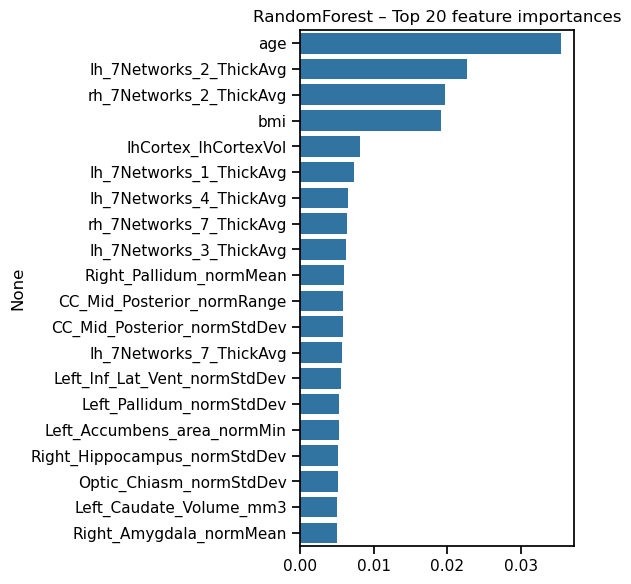

In [50]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

target_col = 'p_factor'
drop_cols = ['subject_id', 'session_id']

X = train_merged.drop(columns=[c for c in drop_cols if c in train_merged.columns] + ([target_col] if target_col in train_merged.columns else []))
y = train_merged[target_col] if target_col in train_merged.columns else None

X = X.select_dtypes(include=[np.number])
print('X shape (numeric):', X.shape)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(Xtr, ytr)
pred = rf.predict(Xte)
print('Baseline R2:', r2_score(yte, pred))
print('Baseline MAE:', mean_absolute_error(yte, pred))

# Importance
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(6,6))
sns.barplot(x=imp.values, y=imp.index)
plt.title('RandomForest – Top 20 feature importances')
plt.tight_layout()
plt.show()


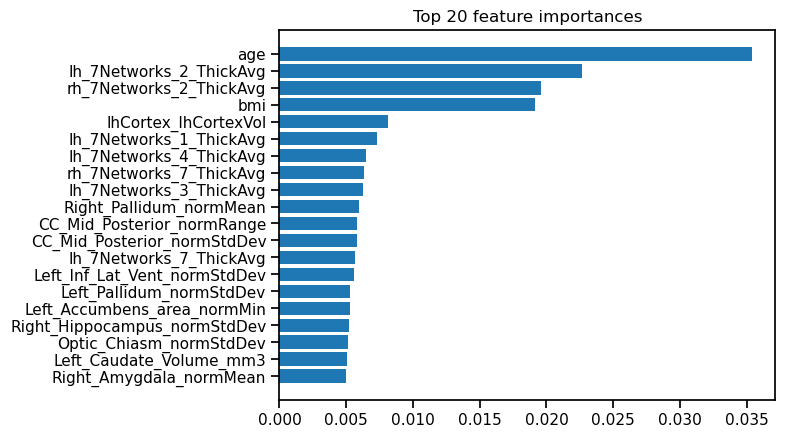

p_factor                          1.000000
age                               0.216842
bmi                               0.156737
Right_Pallidum_normMean           0.151555
Left_Thalamus_Proper_normMean     0.135463
Right_Thalamus_Proper_normMax     0.131182
Left_VentralDC_normMean           0.130551
Right_VentralDC_normMean          0.130209
Right_Thalamus_Proper_normMean    0.128271
Left_Pallidum_normMean            0.122282
Name: p_factor, dtype: float64
Left_non_WM_hypointensities_normMin      NaN
Right_non_WM_hypointensities_normMin     NaN
Left_WM_hypointensities_normMax          NaN
Right_WM_hypointensities_normMax         NaN
Left_non_WM_hypointensities_normMax      NaN
Right_non_WM_hypointensities_normMax     NaN
Left_WM_hypointensities_normRange        NaN
Right_WM_hypointensities_normRange       NaN
Left_non_WM_hypointensities_normRange    NaN
Right_non_WM_hypointensities_normRange   NaN
Name: p_factor, dtype: float64


In [51]:
# Feature importance sanity check
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

importances = rf.feature_importances_
top_idx = np.argsort(importances)[-20:]
plt.barh(range(20), importances[top_idx])
plt.yticks(range(20), X.columns[top_idx])
plt.title("Top 20 feature importances")
plt.show()

# Correlation with p_factor
corrs = X.assign(p_factor=y).corr()['p_factor'].sort_values(ascending=False)
print(corrs.head(10))
print(corrs.tail(10))



## 5. Predict Test and Save


In [ ]:

out_dir = Path('./outputs')
out_dir.mkdir(exist_ok=True)

X_test = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])
X_test = X_test.select_dtypes(include=[np.number])

missing_cols = [c for c in X.columns if c not in X_test.columns]
for c in missing_cols:
    X_test[c] = np.nan
extra_cols = [c for c in X_test.columns if c not in X.columns]
X_test = X_test.drop(columns=extra_cols, errors='ignore')
X_test = X_test[X.columns]

test_pred = rf.predict(X_test)
submission = test_df[['subject_id']].copy()
submission['p_factor'] = test_pred

train_df.to_csv(out_dir / 'train_flattened.csv', index=False)
test_df.to_csv(out_dir / 'test_flattened.csv', index=False)
submission.to_csv(out_dir / 'submission_baseline.tsv', sep='\t', index=False)

print('Saved:')
print(' -', out_dir / 'train_flattened.csv')
print(' -', out_dir / 'test_flattened.csv')
print(' -', out_dir / 'submission_baseline.tsv')



### Optional: PCA preview


In [ ]:

if 'p_factor' in train_df.columns:
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'p_factor' in numeric_cols:
        numeric_cols.remove('p_factor')
    X_num = train_df[numeric_cols].fillna(train_df[numeric_cols].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_num)
    pca = PCA(n_components=2, random_state=42)
    XY = pca.fit_transform(X_scaled)
    plt.figure(figsize=(5,4))
    sc = plt.scatter(XY[:,0], XY[:,1], c=train_df['p_factor'], alpha=0.6)
    plt.colorbar(sc, label='p_factor')
    plt.title('PCA (2D) colored by p_factor')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()
